In [3]:
import os
from collections import Counter

import PIL.Image as Image
import numpy as np
import torch
import torch.nn as nn
import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, classification_report, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights

import wandb

In [4]:
from src.config import SPLIT_TRAIN_DIR, SPLIT_VAL_DIR, SPLIT_TEST_DIR

In [5]:
# List cuda devices

In [6]:
# GET mean size of images

images = os.listdir(f'{SPLIT_TRAIN_DIR}/her2-enriched')

sizes = []

for image in images:
    img = Image.open(os.path.join(f'{SPLIT_TRAIN_DIR}/her2-enriched', image))

    sizes.append(img.size)

sizes = np.array(sizes)

print(sizes.mean(axis=0))



[ 827.66049383 2049.05555556]


In [7]:
mean_size = np.array([827.66049383, 2049.05555556])

# Nueva altura deseada
new_height = 224

# Calcular el nuevo ancho manteniendo el aspect ratio
aspect_ratio = mean_size[1] / mean_size[0]
new_width = int(new_height * aspect_ratio)

print(new_width, new_height)

554 224


In [8]:
# Load dataset from directory

transform = transforms.Compose([
    transforms.Resize((554, 224)),
    transforms.ToTensor(),
])

train = datasets.ImageFolder(SPLIT_TRAIN_DIR, transform=transform)
val = datasets.ImageFolder(SPLIT_VAL_DIR, transform=transform)
test = datasets.ImageFolder(SPLIT_TEST_DIR, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)



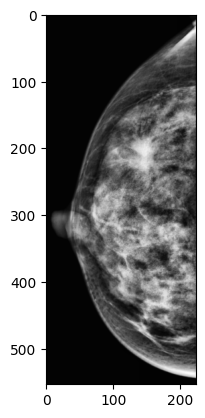

luminal-a


In [9]:
# Show one image

import matplotlib.pyplot as plt

image, label = train[246]

image = image.permute(1, 2, 0)

plt.imshow(image)

plt.show()

print(train.classes[label])


In [10]:
classes = train.classes

# Calcular la frecuencia de cada clase
counter = Counter(train.targets)
min_class = min(counter, key=counter.get)

class_weights = compute_class_weight('balanced', classes=np.unique(train.targets), y=train.targets)

class_weights = torch.tensor(class_weights, dtype=torch.float32)

class_weights

tensor([1.3858, 1.2335, 0.4989, 2.1587])

In [11]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")

In [12]:
class_weights = class_weights.to(device)

In [13]:
# Try transfer learning
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# freeze all layers

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

In [14]:
model = model.to(device)

LR = 0.0001

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

EPOCHS = 100

In [ ]:
run = wandb.init(
    entity="dacxjoub",
    project="project-aletheia",
    config={
        "learning_rate": LR,
        "architecture": "ResNet50",
        "dataset": "CMMD-2",
        "epochs": EPOCHS,
    },
)

try:
    for epoch in range(EPOCHS):
        print("Epoch {}/{}".format(epoch + 1, EPOCHS))
        print("-" * 10)

        model.train()
        running_loss = 0.0
        y_true = []
        y_pred = []
        y_probs = []

        for inputs, labels in tqdm.tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().detach().numpy())
            y_pred.extend(predicted.cpu().detach().numpy())
            y_probs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = accuracy_score(y_true, y_pred)
        epoch_f1 = f1_score(y_true, y_pred, average='weighted')
        epoch_recall = recall_score(y_true, y_pred, average='weighted')
        epoch_auc = roc_auc_score(y_true, y_probs, multi_class='ovr')

        print("Loss: {:.4f}".format(epoch_loss))
        print("Accuracy: {:.4f}".format(epoch_accuracy))
        print("F1 Score: {:.4f}".format(epoch_f1))
        print("Recall: {:.4f}".format(epoch_recall))
        print("AUC: {:.4f}".format(epoch_auc))

        run.log({
            "train_loss": epoch_loss,
            "train_accuracy": epoch_accuracy,
            "train_f1": epoch_f1,
            "train_recall": epoch_recall,
            "train_auc": epoch_auc
        })

    run.finish()
except Exception as e:
    run.finish()
    print(e)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dblandto7 (dacxjoub) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/100
----------


 33%|███▎      | 5/15 [00:14<00:26,  2.63s/it]

In [21]:
model.eval()

running_loss = 0.0

y_true = []

y_pred = []

y_prob = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())

epoch_loss = running_loss / len(val_loader.dataset)

print("Loss: {:.4f}".format(epoch_loss))

print(classification_report(y_true, y_pred, target_names=classes))

print(roc_auc_score(y_true, y_prob, multi_class='ovr'))

100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

Loss: 1.3515
                 precision    recall  f1-score   support

  her2-enriched       0.20      0.20      0.20        54
      luminal-a       0.22      0.33      0.27        60
      luminal-b       0.54      0.47      0.51       152
triple-negative       0.13      0.09      0.11        34

       accuracy                           0.35       300
      macro avg       0.27      0.27      0.27       300
   weighted avg       0.37      0.35      0.36       300

0.5483951752880071


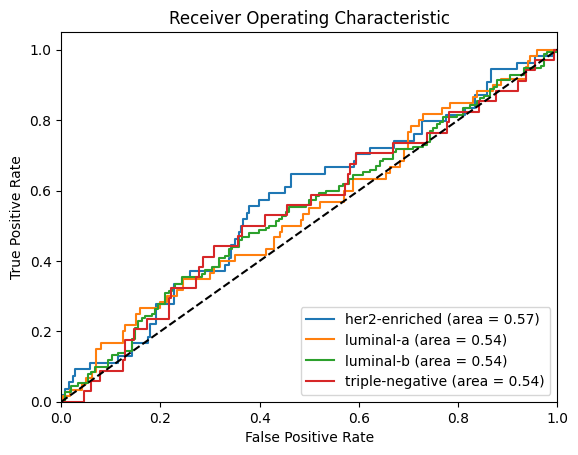

In [24]:
# Plot ROC curve

import matplotlib.pyplot as plt

fpr = dict()

tpr = dict()

roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_prob)[:, i])

    roc_auc[i] = roc_auc_score(np.array(y_true) == i, np.array(y_prob)[:, i])

    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")

plt.show()
